# InSituPy demonstration - Analyze data

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import scanpy as sc
from insitupy import read_xenium

## Previous steps

1. Download the example data for demonstration: [01_InSituPy_demo_download_data.ipynb](./01_InSituPy_demo_download_data.ipynb).
2. Register images from external stainings: [02_InSituPy_demo_register_images.ipynb](./02_InSituPy_demo_register_images.ipynb)

At this point, the structure of the data should look like this:

    ```
    ./demo_dataset
    ├───output-XETG00000__slide_id__sample_id
    │   ├───analysis
    │   │   ├───clustering
    │   │   ├───diffexp
    │   │   ├───pca
    │   │   ├───tsne
    │   │   └───umap
    │   └───cell_feature_matrix
    ├───registered_images
    ├───registration_qc
    └───unregistered_images
    ```


## Load Xenium data into `XeniumData` object

Now the Xenium data can be parsed by providing the data path to `XeniumData`

In [3]:
# prepare paths
out_dir = Path("demo_dataset") # output directory
data_dir = out_dir / "output-XETG00000__0001879__Replicate 1" # directory of xenium data
image_dir = out_dir / "unregistered_images" # directory of images

In [4]:
xd = read_xenium(data_dir)

In [5]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	output-XETG00000__0001879__Replicate 1
Metadata file:	experiment_modified.xenium

In [7]:
# read all data modalities at once
xd.load_all()

# alternatively, it is also possible to read each modality separately
# xd.load_cells()
# xd.load_images()
# xd.load_transcripts()
# xd.read_annotations()

Loading annotations...
No `annotations` modality found.
Loading cells...
Loading images...
Loading regions...
No `regions` modality found.
Loading transcripts...


Note: That the `annotations` modality is not found here is expected. Annotations are added in a later step.

In [8]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	output-XETG00000__0001879__Replicate 1
Metadata file:	experiment_modified.xenium
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 167780 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               nuclear
               cellular
    ➤ transcripts
       DataFrame with shape 42638083 x 7

## Working with an `InSituPy` project

To allow a simple and structured saving workflow, `InSituPy` provides two saving functions:
- `saveas()`
- `save()`

### Save as `InSituPy` project

In [9]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [9]:
xd.saveas(insitupy_project, overwrite=True)

Saving data to demo_dataset\demo_insitupy_project
Saved.


### Reload from `InSituPy` project

From the `InSituPy` project we can now load only the modalities that we need for later analyses. Due to an optimized file structure using `zarr` and `dask`, this makes loading and visualization of the data more efficient compared to doing this directly from the xenium bundle.

In [10]:
xd = read_xenium(insitupy_project)

In [11]:
xd

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy

In [12]:
xd.load_cells()
xd.load_images()

Loading cells...
	No alternative cells found...
Loading images...


## Explore data in interactive `napari` viewer

Example image of the viewer:

<left><img src="./demo_screenshots/whole_napari_viewer.png" width="800"/></left>

For detailed documentation on the functionalities of `napari` see the official documentation [here](https://napari.org/stable/index.html).

In [27]:
xd.show()

### Explore gene expression using `napari` viewer

Use the `"Add cells"` widget to explore the single-cell transcriptomic data.

<left><img src="./demo_screenshots/add_cells.jpg" width="350"/></left>

Genes can be selected from the dropdown window by scrolling or by clicking into the window and typing the name of the item:

<left><img src="./demo_screenshots/select_gene.jpg" width="350"/></left>

After selection of an item it can be added using the `"Add"` button. The data is added as point layer to the napari viewer.

### Crop data using the `napari` viewer

Steps for cropping:
1. Use the `"New shapes layer"` button to add a new layer of shapes: 

<left><img src="./demo_screenshots/shapes_layer.jpg" height="40"/></left>

2. Use the `"Add rectangles"` button to select a rectangular region: 

<left><img src="./demo_screenshots/annotation_tools.jpg" height="80"/></left>

3. Rename the shapes layer or leave the default name `"Shapes"`.
4. Move back to Jupyter Notebook and run `xd.crop()`.

In [29]:
xd_cropped = xd.crop(shape_layer="Shapes")

# alternatively you can also crop using the xlim/ylim arguments
#xd.crop(xlim=(10000,11000), ylim=(12000,14000))

In [30]:
xd_cropped


XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(9017, 9531)
       CD20:	(9017, 9531)
       HER2:	(9017, 9531)
       HE:	(9017, 9531, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 21496 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       demo:	2 annotations, 1 class ('Positive') 
    ➤ regions
       demo_regions:	2 regions, 2 classes ('Region1','Region3') 
       TMA:	1 regions, 1 class ('A-1') 

In [31]:
# show cropped data
xd_cropped.show()

## Saving the cropped data

### Saving to the existing project path is not possible

Due to the cropping event, saving to the existing project path is not possible and the `.save()` function throws an error:

In [32]:
xd_cropped.save()

C:\Users\ge37voy\Github\InSituPy\insitupy\_core\insitudata.py:1333: UserWarning: UID of current object 878190e4-1992-4f9d-bf05-4399c860e518 not identical with UID in project path c:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project: 2254ba29-0665-4597-8e38-5261fd078d4a.
Project is neither saved nor updated. Try `saveas()` instead to save the data to a new project folder. A reason for this could be the data has been cropped in the meantime.
  warn(


Reload also does not work because it was not saved as an `InSituPy` project.

In [33]:
xd_cropped.reload()

No modalities with existing save path found. Consider saving the data with `saveas()` first.


### Saving to new project directory

In [34]:
cropped_insitupy_project = insitupy_project.parent / f"{insitupy_project.name}_cropped"

In [35]:
xd_cropped.saveas(cropped_insitupy_project, overwrite=True)

Saving data to demo_dataset\demo_insitupy_project_cropped
Saved.


### Reload from `InSituPy` project folder

Reloading from project folder makes visualizations more efficient. But of course only the modalities that had been loaded before the cropping event can be reloaded in this step.

In [36]:
# reload from insitupy project
xd_cropped = read_xenium(cropped_insitupy_project)
xd_cropped.load_all()

Loading annotations...
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...
No `transcripts` modality found.


In [37]:
xd_cropped

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project_cropped
Metadata file:	.ispy
    ➤ images
       nuclei:	(9017, 9531)
       CD20:	(9017, 9531)
       HER2:	(9017, 9531)
       HE:	(9017, 9531, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 21496 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area'
           var: 'gene_ids', 'feature_types', 'genome'
           obsm: 'spatial'
           varm: 'binned_expression'
       boundaries
           BoundariesData object with 2 entries:
               cellular
               nuclear
    ➤ annotations
       demo:	2 annotations, 1 class ('Positive') 
    ➤ regions
       demo_regions:	2 regions, 2 classes ('Region1','Region3') 
       TMA:	1 regions, 1 class ('A-1') 

## Perform preprocessing steps

`InSituPy` also includes basic preprocessing functions to normalize the transcriptomic data and perform dimensionality reduction. For normalization, the ``ScanPy`` function `sc.pp.normalize_total()` is used. Data transformation can be either done using logarithmic transformation or square root transformation as suggested [here](https://stlearn.readthedocs.io/en/latest/tutorials/Xenium_PSTS.html).


### Filtering

In [38]:
sc.pp.filter_cells(xd_cropped.cells.matrix, min_genes=10)

Filtering of cells happens on the level of `.cells.matrix`. To synchronize the cells included in `.cells.matrix` after the filtering and their boundaries in `.cells.boundaries`, `.sync_cell_ids` can be called on `.cells`.

In [39]:
xd_cropped.cells.sync_cell_ids()

Successfully synchronized.


### Normalization and dimensionality reduction

In [40]:
xd_cropped.normalize(transformation_method="sqrt")
xd_cropped.reduce_dimensions(umap=True, tsne=False)

Store raw counts in anndata.layers['counts']...
Normalization, sqrt-transformation...
Dimensionality reduction...
Leiden clustering...


### Show results using `scanpy` functions

c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


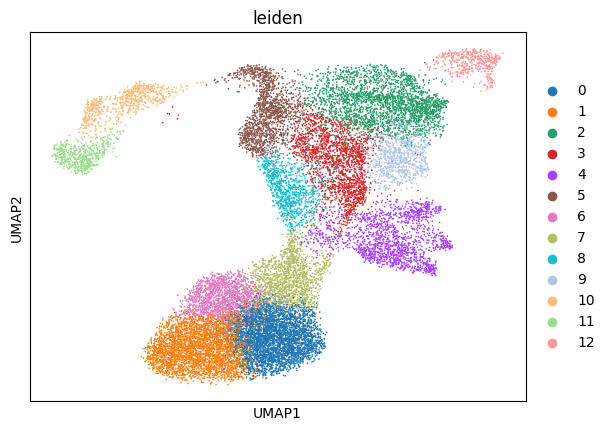

In [41]:
sc.pl.umap(xd_cropped.cells.matrix, color="leiden")

In [42]:
# show cropped data
xd_cropped.show()

#### Start viewer with list of selected genes

Alternatively to selecting genes inside the napari viewer, it is also possible to open the viewer directly including a list of genes.

In [43]:
xd_cropped.show(keys=["leiden", "ACTA2", "LYZ", "LUM"])

Genes can be displayed or hidden via the eye symbol: <br>
<left><img src="./demo_screenshots/gene_selection.jpg" height="70"/></left>

## Save results within `InSituPy` project

The cropped and/or processed data can be saved into a folder using the `.saveas()` function of `InSituData`.

The resulting folder has following structure (can vary depending on which modalities have been loaded before):
```
cropped_processed
│   .ispy
│
├───cells
│   └───uid
│       │   .celldata
│       │
│       ├───boundaries
│       │       cellular.zarr.zip
│       │       nuclear.zarr.zip
│       │
│       └───matrix
│               matrix.h5ad
│
├───images
│       morphology_mip.zarr.zip
│       slide_id__sample_id__CD20__registered.zarr.zip
│       slide_id__sample_id__HER2__registered.zarr.zip
│       slide_id__sample_id__HE__registered.zarr.zip
│
└───transcripts
        transcripts.parquet
```

In [44]:
xd_cropped.save()

Updating project in c:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project_cropped
	Updating cells...
	Updating annotations...
	Updating regions...
Saved.
Reloading following modalities: annotations,cells,images,regions
Loading annotations...
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...


## Reload data

In [45]:
xd_reloaded = read_xenium(cropped_insitupy_project)

In [46]:
xd_reloaded

XeniumData
Slide ID:	0001879
Sample ID:	Replicate 1
Data path:	demo_dataset
Data folder:	demo_insitupy_project_cropped
Metadata file:	.ispy

In [47]:
xd_reloaded.load_all()

Loading annotations...
Loading cells...
	No alternative cells found...
Loading images...
Loading regions...
No `transcripts` modality found.


In [48]:
xd_reloaded.show()